#### Get Screenshot
capture_window_content() <br>
INPUT screen resolutions: OUTPUT screenshot of playing area

In [66]:
import pygetwindow as gw
import numpy as np
from PIL import Image
from desktopmagic.screengrab_win32 \
import(getDisplayRects,saveScreenToBmp,getScreenAsImage,getRectAsImage,getDisplaysAsImages)


def capture_window_content(ldis__width=2560, ldis__height=1080, rdis_width=2496, rdis_height=1664):
    #input actual resolution of both screens (desktopmagic does not reliability or consistently identify monitor resolutions)
    #based on resolutions captured by desktopmagic caluclate a ratio between identified and true resolutions
    #Identify the bounds of the "global poker" window
    #adjust the bounds of the window area based on resultion ratio, window border size and playing area size
    
    screen_bounds = getDisplayRects()
    screen_bounds_max = max([max(l,t,r,b) for l,t,r,b in screen_bounds])

    #take screenshot of window who's title has 'Global Poker', if none found, screenshot the whole display
    windows = gw.getAllTitles()
    if len([item for item in windows if "Global Poker" in item])>0:
        window_title = [item for item in windows if "Global Poker" in item][0]
        # Get the window by title
        window = gw.getWindowsWithTitle(window_title)[0]
        # Get window coordinates
        left, top, right, bottom = window.left, window.top, window.right, window.bottom
    else: 
        left, top, right, bottom = screen_bounds[0][0], screen_bounds[0][1], screen_bounds[0][2], screen_bounds[0][3]

    if len(screen_bounds) ==1:
        ldis__width = rdis_width
        ldis__height = rdis_height

    #captured ratio to actual 0: right, 1: left
    if len(screen_bounds) == 1:
        l, t, r, b = screen_bounds[0]
        ldis_widht_comp = r - l
        ldis_height_comp = b - t
        ldis_width_ratio = (r - l)/ldis__width
        ldis_height_ratio = (b - t)/ldis__height    
    else:
        l, t, r, b = screen_bounds[1]
        ldis_widht_comp = r - l
        ldis_height_comp = b - t
        ldis_width_ratio = (r - l)/ldis__width
        ldis_height_ratio = (b - t)/ldis__height
        l, t, r, b = screen_bounds[0]
        rdis_width_comp = r - l
        rdis_height_comp = b - t
        rdis_width_ratio = (r - l)/rdis_width
        rdis_height_ratio = (b - t)/rdis_height

    #screen bounds
    l, t, r, b = screen_bounds[0]
    second_display_top, second_display_left = t, l
    rdis_cutoff = int(second_display_left * 0.99)
    ldis_cutoff = int(second_display_left * 1.01)
    
    #set top and bottom window border ratios to actual dimensions
    dis_lbar_ratio, dis_rbar_ratio, dis_tbar_ratio, dis_bbar_ratio = 0.024, 0.005, 0.1528, 0.011
    #set left and right window border ratios based on top border
    dis_lbar_ratio = 0.365
    dis_rbar_ratio = 0.07

    #set adjustments based on window and resolution
    #if one screen
    if len(screen_bounds) == 1:
        left = int(left/ldis_width_ratio)
        right = int(right/ldis_width_ratio)
        top = int(top/ldis_height_ratio)
        bottom = int(bottom/ldis_height_ratio)
        title_bar_height = int((ldis_height_comp/ldis_height_ratio) * (dis_tbar_ratio))
        bottom_bar_height = int((ldis_height_comp/ldis_height_ratio) * (dis_bbar_ratio))
        right_bar_width = int(title_bar_height * dis_rbar_ratio)
        left_bar_width = int(title_bar_height * dis_lbar_ratio) 
    #if multiple screens
    elif left < ldis_cutoff and right < ldis_cutoff: #left display
        left = int(left * ldis_width_ratio)
        right = int(right * ldis_width_ratio)
        top = int(top * ldis_height_ratio)
        bottom = int(bottom * ldis_height_ratio)
        title_bar_height = int((ldis_height_comp/ldis_height_ratio) * (dis_tbar_ratio))
        bottom_bar_height = int((ldis_height_comp/ldis_height_ratio) * (dis_bbar_ratio))
        right_bar_width = int(title_bar_height * dis_rbar_ratio)
        left_bar_width = int(title_bar_height * dis_lbar_ratio)     
    elif left > rdis_cutoff and right > rdis_cutoff: #right display
        left = int((left - second_display_left)/rdis_width_ratio + (second_display_left/ldis_width_ratio))
        right = int((right - second_display_left)/rdis_width_ratio + (second_display_left/ldis_width_ratio))
        top = int((top - second_display_top)/rdis_height_ratio + (second_display_top))
        bottom = int((bottom - second_display_top)/rdis_height_ratio + (second_display_top))
        title_bar_height = int((rdis_height_comp/rdis_height_ratio) * (dis_tbar_ratio))
        bottom_bar_height = int((rdis_height_comp/rdis_height_ratio) * (dis_bbar_ratio))
        right_bar_width = int(title_bar_height * dis_rbar_ratio)
        left_bar_width = int(title_bar_height * dis_lbar_ratio)  
    else: print('split screen')

    #Remove window borders
    content_left = int(left + left_bar_width)
    content_top = int(top + title_bar_height)
    content_right = int(right - right_bar_width)
    content_bottom = int(bottom - bottom_bar_height)

    #get rid of black widht or heigh fill bars (these keep the playing area at a 16:9 display ratio), focus on play area only
    width = content_right - content_left
    height = content_bottom - content_top
    ideal_height = width/16 * 9
    if ideal_height < height:
        fill_bar = (ideal_height - height)/2
        content_top -= int(fill_bar)
        content_bottom += int(fill_bar)
    if ideal_height > height:
        ideal_width = height/9 * 16
        fill_bar = (width - ideal_width)/2
        content_left += int(fill_bar)
        content_right -= int(fill_bar)
    
    #take screenshot of play area
    screenshot = getRectAsImage((content_left, content_top, content_right, content_bottom))

    return screenshot

# capture_window_content(2496,1664).show()

#### Find Card Values
find_flop_rank() <br>
INPUT screenshot: OUTPUT list of flop values (string [A-2]) <br><br>
find_hole_rank() <br>
INPUT screenshot: OUTPUT list of hole values (string [A-2])

In [100]:
import cv2 
import numpy as np 
from matplotlib import pyplot as plt 
from PIL import Image
from pytesseract import pytesseract


def find_flop_rank(screenshot):
    #input screenshot
    #turn image into black and white array, find thresholds and contours of that image
    #find the contour rectangles that are approximatley the right size to be flop
    #search for text on those cards

    #import image as array
    image = screenshot
    image = np.array(image)

    #find contours
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
    ret, thresh = cv2.threshold(gray, 127, 255, 0)
    contours, what = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    #set bounds of card size based on proportions to the image
    cardwidth_imagewidth_max, cardwidth_imagewidth_min, cardwidth_height = 0.09, 0.05, 1.37 #manually configured proportions
    widths_low, widths_high = len(image[0]) * cardwidth_imagewidth_min, len(image[0]) * cardwidth_imagewidth_max
    heights_low, heights_high = widths_low * cardwidth_height, widths_high * cardwidth_height

    #for each contour that fits size parameters crop a new image and store it
    card_images = []
    for countour in contours:  
        x, y, w, h = cv2.boundingRect(countour)
        #choose only imaged that fit the configured parameters
        if widths_low <= w <= widths_high and heights_low <= h <= heights_high:
            cv2.rectangle(image, (x,y), (x + w, y + h), (0,255,0), 2)
            card_image = gray[y:y+h, x:x+w]
            card_images.append(card_image)

    #set adjustment factor for each card to crop it down to just the number in top left
    width_crop, height_crop = 0.75, 0.26
    width = int(len(card_images[0]) * width_crop)
    height =  int(len(card_image) * height_crop)

    #crop each card down to just the number and perform text regocognition on it
    card_values = []
    for card in card_images:
        image = Image.fromarray(card)
        image = image.crop((0,0,width,height))
        #set parameters to psm 10: find single character, whitelist: expected card characters
        custom_config = r'--oem 3 --psm 10 -c tessedit_char_whitelist=0123456789AKQJ' 
        text = pytesseract.image_to_string(image, config=custom_config)
        card_value = text[:1]
        if card_value == "1": card_value = "T"
        card_values.append(card_value)

    #flip the order of the values since the program recognizes countours from right to left
    card_values_return = [card_values[(x + 1) * -1] for x in range(len(card_values))]
    return card_values_return

screenshot = capture_window_content()
find_flop_rank(screenshot)


['K', '2', 'T', 'Q']

In [20]:
def find_hole_rank(screenshot):
    #input screenshot
    #turn image into black and white array, find thresholds and contours of that image
    #find the contour rectangles that are approximatley the right size and in the right location to be hole cards
    #there will only be one countour for both hole cards so that image will need to be divided manually
    #search for text on those cards
    
    #import image as array
    image = screenshot
    image = np.array(image)

    #find contours
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
    ret, thresh = cv2.threshold(gray, 127, 255, 0)
    contours, what = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    #set bounds of card size based on proportions to the image
    cardwidth_imagewidth_max, cardwidth_imagewidth_min, cardwidth_height = 0.15, 0.04, 0.7 #manually configured proportions
    widths_low, widths_high = len(image[0]) * cardwidth_imagewidth_min, len(image[0]) * cardwidth_imagewidth_max
    heights = [h for x,y,w,h in[cv2.boundingRect(contour) for contour in contours]]
    heights_low, heights_high = widths_low * cardwidth_height, widths_high * cardwidth_height

    #set bounds of card location based on proportions to the image
    half_height = len(image) * 0.5 #manually set proportions
    left_width = len(image[0]) * 0.3
    right_width = len(image[0]) - (len(image[0]) * 0.3)
    
    #for each contour that fits size parameters crop a new image and store it, should only result in one image
    card_images = []
    for countour in contours:  
        x, y, w, h = cv2.boundingRect(countour)
        #choose only countours that fit the configured parameters
        cv2.rectangle(image, (x,y), (x + w, y + h), (255,255,255), 2)
        if widths_low <= w <= widths_high and heights_low <= h <= heights_high and left_width < x < right_width  and y > half_height:
            cv2.rectangle(image, (x,y), (x + w, y + h), (255,255,255), 2)
            card_image = gray[y:y+h, x:x+w]
            card_images.append(card_image)

    #set the approximate bounds for the first and second cards in the hole image based on size of overall image
    first_width = len(image[0]) * 0.025 #manually configured proportions
    height = len(image) * 0.038
    first_bounds = [0,0, first_width, height]
    second_bounds = [first_width, 0, first_width + first_width, height]

    #first hole card - crop and perform text analysis
    #set parameters to psm 10: find single character, whitelist: expected card characters
    card_values = []
    image = Image.fromarray(card_images[0])
    image = image.crop((0,0,first_bounds[2],first_bounds[3])).crop()
    custom_config = r'--oem 3 --psm 10 -c tessedit_char_whitelist=0123456789AKQJ' 
    text = pytesseract.image_to_string(image, config=custom_config)
    card_value = text[:1]
    if card_value == "1": card_value = "T"
    card_values.append(card_value)

    #second hole card - crop and perform text analysis
    #set parameters to psm 10: find single character, whitelist: expected card characters
    image = Image.fromarray(card_images[0])
    image = image.crop((second_bounds[0],0,second_bounds[2],second_bounds[3])).crop()
    custom_config = r'--oem 3 --psm 10 -c tessedit_char_whitelist=0123456789AKQJ' 
    text = pytesseract.image_to_string(image, config=custom_config)
    card_value = text[:1]
    if card_value == "1": card_value = "T"
    card_values.append(card_value)

    return card_values

# screenshot = capture_window_content()
# find_hole_rank(screenshot)


#### Find Card Suits
find_flop_suit() <br>
INPUT screenshot: OUTPUT list of flop suits (string) <br><br>
find_hole_suit() <br>
INPUT screenshot: OUTPUT list of hole sutis (string)


In [75]:
import cv2
import numpy as np

def find_flop_suit (image_input):   
    #input screenshot of poker playing area
    #turn image into black and white array, find thresholds and contours of that image
    #find the contour rectangles that are approximatley the right size to be flop
    #there will only be one countour for both hole cards so that image will need to be divided manually
    #each suit has a specific color, check for the presence of this color to determine suit

    #import image as array
    image = image_input
    image = np.array(image)

    #find contours
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
    ret, thresh = cv2.threshold(gray, 127, 255, 0)
    contours, what = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    #set bounds of card size based on proportions to the image
    cardwidth_imagewidth_max, cardwidth_imagewidth_min, cardwidth_height = 0.09, 0.05, 1.37 #manually configured proportions
    widths_low, widths_high = len(image[0]) * cardwidth_imagewidth_min, len(image[0]) * cardwidth_imagewidth_max
    heights_low, heights_high = widths_low * cardwidth_height, widths_high * cardwidth_height

    #for each contour that fits size parameters crop a new image and store it
    card_images = []
    for countour in contours:  
        x, y, w, h = cv2.boundingRect(countour)
        if widths_low <= w <= widths_high and heights_low <= h <= heights_high:
            cv2.rectangle(image, (x,y), (x + w, y + h), (0,255,0), 2)
            #crop the image slightly further to make sure background not present
            y = int(y + 20)
            x = int(x + 20)
            h = int(h - 40)
            w = int(w - 40)
            card_image = image[y:y+h, x:x+w]
            card_images.append(card_image)


    #set bounds for 4 suit colors: Red=hearts, blue=diamonds, black=spades, green=clubs
    red_lower_color = np.array([160, 5, 10])  
    red_upper_color = np.array([240, 75, 90])  
    blue_lower_color = np.array([0, 0, 150])  
    blue_upper_color = np.array([70, 70, 255])  
    black_lower_color = np.array([0, 0, 0])  
    black_upper_color = np.array([75, 75, 75])  
    green_lower_color = np.array([40, 125, 20])  
    greem_upper_color = np.array([100, 180, 80])  

    #for each card image find what color is present by applying color masks and checking if any values fit
    card_suits = []
    for card_image in card_images:
        red_mask = cv2.inRange(card_image, red_lower_color, red_upper_color)
        blue_mask = cv2.inRange(card_image, blue_lower_color, blue_upper_color)
        black_mask = cv2.inRange(card_image, black_lower_color, black_upper_color)
        green_mask = cv2.inRange(card_image, green_lower_color, greem_upper_color)   
        if np.any(red_mask): card_suits.append("H")
        if np.any(blue_mask): card_suits.append("D")
        if np.any(black_mask): card_suits.append("S")
        if np.any(green_mask): card_suits.append("C")
    
    #reverse the order of suits since the countours read right to left
    card_suits_return = [card_suits[(x + 1) * -1] for x in range(len(card_suits))]
    return card_suits_return

screenshot = capture_window_content()
find_flop_suit(screenshot)

[]

In [121]:
    
def find_hole_suit(screenshot, auto=True):
    #input screenshot of poker playing area
    #turn image into black and white array, find thresholds and contours of that image
    #find the contour rectangles that are approximatley the right size to be flop
    #each suit has a specific color, check for the presence of this color to determine suit

    #input image as array
    image = screenshot
    image = np.array(image)

    #find countours
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
    ret, thresh = cv2.threshold(gray, 127, 255, 0)
    contours, what = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    #set bounds of card size based on proportions to the image
    cardwidth_imagewidth_max, cardwidth_imagewidth_min, cardwidth_height = 0.15, 0.04, 0.7 #manually configured proportions
    widths_low, widths_high = len(image[0]) * cardwidth_imagewidth_min, len(image[0]) * cardwidth_imagewidth_max
    heights_low, heights_high = widths_low * cardwidth_height, widths_high * cardwidth_height

    #set bounds of card location based on proportions to the image
    full_height = len(image) * 0.5 #manually set proportions
    left_width = len(image[0]) * 0.3
    right_width = len(image[0]) - (len(image[0]) * 0.3)

    #for each contour that fits size and locations parameters crop a new image and store it
    card_images = []
    for countour in contours:  
        x, y, w, h = cv2.boundingRect(countour)
        if widths_low <= w <= widths_high and heights_low <= h <= heights_high and left_width < x < right_width and y > full_height:
            cv2.rectangle(image, (x,y), (x + w, y + h), (0,255,0), 2)
            card_image = image[y:y+h, x:x+w]
            card_images.append(card_image)

    #set bounds for 4 suit colors: Red=hearts, blue=diamonds, black=spades, green=clubs
    red_lower_color = np.array([175, 25, 10, 0])  
    red_upper_color = np.array([225, 75, 70, 255])  
    blue_lower_color = np.array([0, 0, 200, 0])  
    blue_upper_color = np.array([25, 25, 255, 255])  
    black_lower_color = np.array([0, 0, 0, 0])  
    black_upper_color = np.array([25, 25, 25, 255])  
    green_lower_color = np.array([40, 125, 20, 0])  
    greem_upper_color = np.array([100, 180, 70, 255])  
    #when using a manual screenshot for testing vs an automatic screenshot from the program there is a difference in pixel array size
    #this allows you to use either with automatic being the default
    if auto:
        red_lower_color = np.array([160, 5, 10])  
        red_upper_color = np.array([240, 75, 90])  
        blue_lower_color = np.array([0, 0, 150])  
        blue_upper_color = np.array([70, 70, 255])  
        black_lower_color = np.array([0, 0, 0])  
        black_upper_color = np.array([75, 75, 75])  
        green_lower_color = np.array([40, 125, 20])  
        greem_upper_color = np.array([100, 180, 80])  

    #set the approximate bounds for the first and second cards in the hole image based on size of overall image
    first_width = len(image[0]) * 0.025 #manually configured proportions
    height = len(image) * 0.038
    first_bounds = [5,5, first_width, height]
    second_bounds = [first_width, 5, first_width + first_width, height]
    # print(first_bounds)
    # print(second_bounds)

    #first hole card - crop and apply color masks if a color is present define the suit
    card_suits = []
    image = Image.fromarray(card_images[0])
    image = image.crop((first_bounds[0],first_bounds[1],first_bounds[2],first_bounds[3])).crop()
    # image.show() #troubleshooting
    image = np.array(image)
    red_mask = cv2.inRange(image, red_lower_color, red_upper_color)
    blue_mask = cv2.inRange(image, blue_lower_color, blue_upper_color)
    black_mask = cv2.inRange(image, black_lower_color, black_upper_color)
    green_mask = cv2.inRange(image, green_lower_color, greem_upper_color) 
    if np.any(red_mask): card_suits.append("H")
    if np.any(blue_mask): card_suits.append("D")
    if np.any(black_mask): card_suits.append("S")
    if np.any(green_mask): card_suits.append("C")                                     

    #second hole card - crop and apply color masks if a color is present define the suit
    image = Image.fromarray(card_images[0])
    image = image.crop((second_bounds[0],second_bounds[1],second_bounds[2],second_bounds[3])).crop()
    # image.show() #troubleshooting
    image = np.array(image)
    red_mask = cv2.inRange(image, red_lower_color, red_upper_color)
    blue_mask = cv2.inRange(image, blue_lower_color, blue_upper_color)
    black_mask = cv2.inRange(image, black_lower_color, black_upper_color)
    green_mask = cv2.inRange(image, green_lower_color, greem_upper_color) 
    if np.any(red_mask): card_suits.append("H")
    if np.any(blue_mask): card_suits.append("D")
    if np.any(black_mask): card_suits.append("S")
    if np.any(green_mask): card_suits.append("C")   

    return card_suits

screenshot = capture_window_content()
find_hole_suit(screenshot)

['D', 'H']

#### Find Position
find_position() <br>
INPUT screenshot and tablesize: OUTPUT position number

In [106]:
import cv2
import numpy as np
from PIL import Image


def find_position(screenshot, tablesize): #table size 6,8,9
    #input screenshot of playing area
    #crops the image to focus on each predefined position where a player will sit
    #If the colors associated with the "button" are present ID that player position as the "button"
    #If the colors associated with having cards are present ID that player position as "In"
    #Based on location of the button and the players that are in, computer your position

    #8 player table proportional bounds - manually calculated
    pos_8_0 = [0.367, 0.593, 0.617, 1.0]
    pos_8_1 = [0.0, 0.541, 0.365, 0.797]
    pos_8_2 = [0.0, 0.352, 0.323, 0.541]
    pos_8_3 = [0.083, 0.0, 0.384, 0.352]
    pos_8_4 = [0.409, 0.0, 0.634, 0.267]
    pos_8_5 = [0.667, 0.0, 0.938, 0.350]
    pos_8_6 = [0.696, 0.348, 1.0, 0.549]
    pos_8_7 = [0.626, 0.574, 0.897, 0.808]
    pos_8_bounds = [pos_8_0, pos_8_1, pos_8_2, pos_8_3, pos_8_4, pos_8_5, pos_8_6, pos_8_7]

    #9 player table proportional bounds - manually calculated
    pos_9_0 = [0.377, 0.600, 0.583, 1]
    pos_9_1 = [0.122, 0.567, 0.378, 0.805]
    pos_9_2 = [0.0, 0.395, 0.289, 0.589]
    pos_9_3 = [0.0, 0.149, 0.315, 0.373]
    pos_9_4 = [0.264, 0.0, 0.499, 0.298]
    pos_9_5 = [0.499, 0.0, 0.729, 0.328]
    pos_9_6 = [0.698, 0.120, 1, 0.388]
    pos_9_7 = [0.713, 0.395, 1, 0.59]
    pos_9_8 = [0.604, 0.567, 0.864, 0.843]
    pos_9_bounds = [pos_9_0, pos_9_1, pos_9_2, pos_9_3, pos_9_4, pos_9_5, pos_9_6, pos_9_7, pos_9_8]

    #6 player table proportional bounds - manually calculated
    pos_6_0 = [0.373, 0.574, 0.619, 1.0]
    pos_6_1 = [0.0, 0.485, 0.325, 0.731]
    pos_6_2 = [0.0, 0.149, 0.382, 0.388]
    pos_6_3 = [0.386, 0.0, 0.638, 0.257]
    pos_6_4 = [0.65, 0.149, 1.0, 0.447]
    pos_6_5 = [0.646, 0.447, 1.0, 0.783]
    pos_6_bounds = [pos_6_0, pos_6_1, pos_6_2, pos_6_3, pos_6_4, pos_6_5]

    #select bounds list base on table size
    pos_bounds = pos_9_bounds
    pos_button = [0,0,0,0,0,0,0,0,0]
    pos_in = [0,0,0,0,0,0,0,0,0]
    if tablesize == 8: 
        pos_bounds = pos_8_bounds
        pos_button = [0,0,0,0,0,0,0,0]
        pos_in = [0,0,0,0,0,0,0,0]
    if tablesize == 6: 
        pos_bounds = pos_6_bounds
        pos_button = [0,0,0,0,0,0]
        pos_in = [0,0,0,0,0,0]


    #creat list of position images by cropping screenshot based on bounds list and image size
    sc_length, sc_height = screenshot.size
    pos_images = []
    for bound in pos_bounds:
        l_bound = int(bound[0] * sc_length)
        t_bound = int(bound[1] * sc_height)
        r_bound = int(bound[2] * sc_length)
        b_bound = int(bound[3] * sc_height)
        pos_images.append(screenshot.crop((l_bound, t_bound, r_bound, b_bound)))
    button_size_min = int(sc_length * 0.027 / 2)
    button_size_max = int(button_size_min * 2.5)

    #define 'button', 'in' and button_values_total lists to be filled out in for loop
    button_values_total = {} #just for troubleshooting
    #Determine 'in' and 'button' status for each position image
    for pos, pos_image in enumerate(pos_images):
        
        #convert to array
        image = np.array(pos_image)

        #identify profile picture and exclude from color check
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        blurred = cv2.GaussianBlur(gray, (9, 9), 2)
        circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT, dp=1.2, minDist=30, param1=50, param2=30, minRadius=button_size_min, maxRadius=button_size_max)
        if circles is not None:
            circles = np.round(circles[0, :]).astype('int')
            for (x,y,r) in circles:
                cv2.circle(image, (x,y), r, (5, 5, 5), -1)
        # Image.fromarray(image).show()

        #set bounds for color_1 (button grey 1) color 2 (button grey 2) and blue (cards)
        lower_color_1 = np.array([227, 227, 227])  #grey #1
        upper_color_1 = np.array([229, 229, 229])  
        lower_color_2 = np.array([254, 254, 254])  #grey #2
        upper_color_2 = np.array([256, 256, 256])
        lower_blue = np.array([95, 130, 160])  
        upper_blue = np.array([135, 180, 215]) 
        # lower_color_1 = np.array([227, 227, 227,0])  #grey #1
        # upper_color_1 = np.array([229, 229, 229,255])  
        # lower_color_2 = np.array([254, 254, 254,0])  #grey #2
        # upper_color_2 = np.array([256, 256, 256,255])
        # lower_blue = np.array([95, 130, 160,0])  
        # upper_blue = np.array([135, 180, 215,255]) 

        #create masks setting each pixel to true(255) or flase(0) based on if it is within the color range
        color1_mask = cv2.inRange(image, lower_color_1, upper_color_1) 
        color2_mask = cv2.inRange(image, lower_color_2, upper_color_2) 
        blue_mask = cv2.inRange(image, lower_blue, upper_blue)
        
        #determine percent of pixels that satisfy either range of greys (for button) - multiplied by 10,000 for visual clairity
        image_max = (len(image) * len(image[0])) * 255 #value if all pixels were within range
        button_values_total[pos] = [round((sum(sum(color1_mask))/image_max*10000),1), round((sum(sum(color2_mask))/image_max*10000), 1)]

        #Send pct of grey #1 to pos_button for use in next step - grey #1 is more useful for identification, grey #2 kept for troubleshooting
        pos_button[pos] = round((sum(sum(color1_mask))/image_max*10000),1)

        #if position image has greater than threshold of blue value classify that position as 'in'
        blue_pct = round((sum(sum(blue_mask))/image_max*10000),1)
        if blue_pct > 1.5:
            pos_in[pos] = pos+1            
    

    #set maximum value in pos_button to the button (the position with the most grey #1) 
    #reset list so that last two elements are first - done to ofset button placement since button corresponds to position 3 

    pos_in[0] = 1
    # print(pos_button)
    # print(pos_in)

    button_loc = pos_button.index(max(pos_button)) + 1
    pos_in = [x for x in pos_in if x>0][-2:] + [x for x in pos_in if x>0]
    button_loc = pos_in.index(button_loc)
    if button_loc == 0:
        position = 1
    elif button_loc ==1:
        position = 2
    else:
        position = len(pos_in[2:button_loc]) + 3

    #uncomment other return varriables for troubleshooting
    return position #, button_position, pos_button, pos_in, button_values_total

screenshot = capture_window_content()
# screenshot.show()
find_position(screenshot, 6)


2

#### Create Hole Combos
def make_hole_options() <br>
INPUT tight or loose and position: OUTPUT list of possible hole hands

In [110]:
import pandas as pd
import numpy as np
from collections import Counter

def make_hole_options(tight_loose="Base", position=5, restricted=False, flop=["0d","0d","0d"]):
    #create list of all posible two card hands
    #limit that list based on the playable range at position

    #create a dataframe of al 52 posible cards by using merges
    #merge the list of 52 with another list of 52 to create full list of possible 2 card combinations
    cards_nums = pd.DataFrame({'value': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]})
    cards_nums['indexer'] = 1
    cards_suits = pd.DataFrame({'suit': ['S', 'H', 'D', 'C']})
    cards_suits['indexer'] = 1
    cards1 = pd.merge(cards_nums[['indexer','value']], cards_suits, 'left', 'indexer')
    
    #remove cards in the flop from possible hole cards
    flop_suits = [x[1] for x in flop]    
    flop_suits = [x[1] if len(x) == 2 else x[2] for x in flop]
    flop_values = [x[0] for x in flop]
    replacements = {'T': '10', 'J': '11', 'Q': '12', 'K': '13', 'A': '14'}
    flop_values = [replacements.get(item, item ) for item in flop_values]
    truth_statement = (1-((cards1['value'] == int(flop_values[0]))&(cards1['suit'] == flop_suits[0])).astype(int)).astype(bool)
    cards1 = cards1[truth_statement]
    truth_statement = (1-((cards1['value'] == int(flop_values[1]))&(cards1['suit'] == flop_suits[1])).astype(int)).astype(bool)
    cards1 = cards1[truth_statement]
    truth_statement = (1-((cards1['value'] == int(flop_values[2]))&(cards1['suit'] == flop_suits[2])).astype(int)).astype(bool)
    cards1 = cards1[truth_statement]

    #merge list of cards with list of cards to get full list of options
    cards = pd.merge(cards1, cards1, 'left', 'indexer')
    cards.columns = ['indexer', 'value4', 'suit4', 'value5', 'suit5']
    

    #create ID value to identify duplicates then drop them
    mapping = {'S': 1, 'H': 2, 'C': 3, 'D': 4}
    cards['suit4mapped'] = cards['suit4'].map(mapping)
    cards['suit5mapped'] = cards['suit5'].map(mapping)
    cards['list'] = [sorted([a*10+b, c*10+d])for a,b,c,d in zip(cards['value4'],cards['suit4mapped'],cards['value5'],cards['suit5mapped'])]
    cards['id'] = [x[0] + x[1]*1000 for x in cards['list']]
    cards = cards.drop_duplicates(subset='id', keep='last')
    cards['temp'] = [len(Counter(x).values()) for x in cards['list']]
    cards = cards[cards['temp'] > 1]
    cards = cards[['value4','suit4','value5','suit5']]

    #create new ID to identify what cell in the standard poker hand charts the card belongs to
    cards['so'] = 'o'
    cards.loc[cards['suit4'] == cards['suit5'], 'so'] = 's'
    cards['indexer'] = cards[['value4', 'value5']].max(axis=1).astype(str) + cards[['value4', 'value5']].min(axis=1).astype(str) + cards['so']

    #if restricted us the range information to create list of allowable hands
    #if not restricted return the list of possible 2 card hands
    if restricted == True:
        
        #build hands matrix
        cards_list = ['A', 'K', 'Q', 'J', 'T', '9', '8', '7', '6', '5', '4', '3', '2']
        hand = []
        value1 = []
        value2 = []
        so = []
        for i, card in enumerate(cards_list):
            hand.append(card + card)
            value1.append(14-i)
            value2.append(14-i)
            so.append('o')
            for j, card2 in enumerate(cards_list[i+1:]):
                hand.append(card + card2 + 's')
                value1.append(14-i)
                value2.append(14-i-j-1)
                so.append('s')
            for j, card2 in enumerate(cards_list[i+1:]):
                hand.append(card + card2 + 'o')
                value1.append(14-i)
                value2.append(14-i-j-1)
                so.append('o') 

        #turn card matrix into dataframe
        #create ID (value1+value2+suited/unsuited) to merge in next step
        hands = pd.DataFrame({'hand': hand, 'value1': value1, 'value2': value2, 'so': so})
        hands['indexer'] = hands['value1'].astype(str) + (hands['value2']).astype(str) + hands['so']
        hands = hands.reset_index()
    
        #correlate position to excel columns (pos 5/6 and 7/8/9 use the same range information)
        pos_dict = {1: 0, 2: 2, 3: 4, 4: 6, 5: 8, 6: 8, 7: 10, 8: 10, 9:10}
        pos_column = pos_dict[position]

        #import excel containing range information and select the relevant range
        range = pd.read_excel('ranges.xlsx', sheet_name = tight_loose, engine='openpyxl')
        range.columns = range.iloc[0]
        range = range[1:]
        range.reset_index(drop=True, inplace=True)
        range = range.iloc[:,pos_column:pos_column+2].dropna()
        
        #match range information with available hands to create list of hole card combonations in range
        hands = pd.merge(range, hands, 'left', left_on='Index', right_on='index')
        cards = pd.merge(hands[['indexer', 'Action']], cards, 'left', 'indexer')
        cards = cards.dropna()

        #cleanup list of hole card comboninations
        cards['value4'] = cards['value4'].astype(int)
        cards['value5'] = cards['value5'].astype(int)
        cards = cards[['value4', 'suit4', 'value5', 'suit5']]

    return cards


make_hole_options(tight_loose='Loose', position = 5, restricted=True, flop=['AH','KS','TD'])


,value4,suit4,value5,suit5
0,14,D,14,S
1,14,C,14,S
2,14,C,14,D
3,14,D,13,D
4,14,C,13,C
...,...,...,...,...
285,3,D,3,S
286,3,D,3,H
287,3,C,3,S
288,3,C,3,H


#### Determine Preflop Action
def range_instructions () <br>
INPUT hole cards, if playing loose, position, tablesize: OUTPUT list of actions

In [24]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np

def range_instructions (hole, tight_loose="Base", position=5, tablesize=6):
    #import range information from excel - range information contains instructions for actions at each position
    #access the correct instructions for the given hand
    #unpack the instructions (stored in a condensed format)

    #build hands matrix
    cards_list = ['A', 'K', 'Q', 'J', 'T', '9', '8', '7', '6', '5', '4', '3', '2']
    cards_list_value = [14,13,12,11,10,9,8,7,6,5,4,3,2]
    cards_list_dict = {rank: value for rank, value in zip(cards_list, cards_list_value)}
    hand = []
    value1 = []
    value2 = []
    so = []
    for i, card in enumerate(cards_list):
        hand.append(card + card)
        value1.append(14-i)
        value2.append(14-i)
        so.append('o')
        for j, card2 in enumerate(cards_list[i+1:]):
            hand.append(card + card2 + 's')
            value1.append(14-i)
            value2.append(14-i-j-1)
            so.append('s')
        for j, card2 in enumerate(cards_list[i+1:]):
            hand.append(card + card2 + 'o')
            value1.append(14-i)
            value2.append(14-i-j-1)
            so.append('o') 
    
    #turn card matrix into dataframe
    #create ID (value1+value2+suited/unsuited) to merge in next step
    hands = pd.DataFrame({'hand': hand, 'value1': value1, 'value2': value2, 'so': so})
    hands['indexer'] = hands['value1'].astype(str) + (hands['value2']).astype(str) + hands['so']
    hands = hands.reset_index()
    
    #correlate position to excel columns (pos 5/6 and 7/8/9 use the same range information)
    pos_dict = {1: 0, 2: 2, 3: 4, 4: 6, 5: 8, 6: 8, 7: 10, 8: 10, 9:10}
    pos_column = pos_dict[position]

    #import excel containing range information and select the relevant range
    range = pd.read_excel('ranges.xlsx', sheet_name = tight_loose, engine='openpyxl')
    range.columns = range.iloc[0]
    range = range[1:]
    range.reset_index(drop=True, inplace=True)
    range = range.iloc[:,pos_column:pos_column+2].dropna()
    
    #match range information with available hands to create list of hole card combonations in range
    hands = pd.merge(range, hands, 'left', left_on='Index', right_on='index')
    hands['Action'] = hands['Action'].astype(float)

    #configure hole card info into usable ID value to find location in hand matrix
    holes_values = [cards_list_dict[hole[0][0]], cards_list_dict[hole[1][0]]]
    so = 'o'
    if hole[0][1] == hole[1][1]: so = 's'
    hole_id = str(max(holes_values)) + str(min(holes_values)) + so

    #if the ID doesn't match the hand isn't in range and should be folded, otherwise unpack the instructions
    if len(hands[hands['indexer'] == hole_id]) > 0:
        action_code = hands[hands['indexer'] == hole_id].iloc[0,1]

        #extract actions from action code
        action_unpack = {'RFI':[0,10,1], 'EP':[1,1,10], 'MP':[2,0.1,100], 'CO':[3, 0.01,1000], 'BTN':[4,0.001,10000], 'SB limp':[5,0.0001,100000], 'SB raise':[6,0.00001,1000000]}
        act_on = {1:['EP', 'MP', 'CO', 'BTN', 'SB limp', 'SB raise'], 2:['RFI', 'EP', 'MP', 'CO', 'BTN'], 3:['RFI', 'EP', 'MP', 'CO'], 4:['RFI', 'EP', 'MP'], 5:['RFI', 'EP', 'MP'], 6:['RFI', 'EP'], 7:['RFI', 'EP'], 8:['RFI', 'EP'], 9:['RFI', 'EP']}
        rfi_action = {0: 'Fold', 1: 'Raise', 2: 'Limp'}
        bet_action = {0: 'Fold', 1: '3bet', 2: 'Call'}
        sb_action = {0: 'Fold', 1: 'Raise/4bet', 2: 'Raise/Call', 3: 'Raise/Fold', 4: 'Limp/Raise', 5: 'Limp/Call', 6: 'Limp/Fold'}
        actions = {}
        for category in act_on[position]:
            if category == 'EP' and tablesize == 6:
                continue
            action = round(np.mod(action_code * action_unpack[category][2], action_unpack[category][1]*action_unpack[category][2])/action_unpack[category][2], action_unpack[category][0]) * action_unpack[category][2]            
            action_name = category
            if category == 'RFI' and position == 2: 
                    action = sb_action[action]
            elif category == 'RFI':
                    action = rfi_action[action]
            else:
                    action = bet_action[action]
                    action_name = category# + ' ' + 'Raise'

            actions[action_name] = action

    else: actions = "fold"
    # print(actions)

    #create chart for nice presentation of actions
    pos_names = {1: 'Big Blind', 2: 'Small Blind', 3:'Button', 4:'Cutoff', 5:'LoJack', 6:'HiJack', 7:'UTG+2', 8:'UTG+1', 9:'UTG'}
    pos_names_bb = {1: 'SB Raise', 2: 'SB Limp', 3:'Button', 4:'Cutoff', 5:'LoJack', 6:'HiJack', 7:'UTG+2', 8:'UTG+1', 9:'UTG'}
    pos_position_type = {1: 'SB raise', 2: 'SB limp', 3:'BTN', 4:'CO', 5:'MP', 6:'MP', 7:'EP', 8:'EP', 9:'EP'}
    action_color = {'Fold': 'red', '3bet':'green', 'Raise':'green', 'Call':'blue'}
    action_loc = {'Fold': 3, '3bet':1, 'Raise':1, 'Call':2}
    sb_action_color = {'Fold':'red', 'Raise/4bet':'green', 'Raise/Call':'blue', 'Raise/Fold':'orange', 'Limp/Raise':'lime', 'Limp/Call':'aqua', 'Limp/Fold':'red'}
    sb_action_loc = {'Fold':3, 'Raise/4bet':1, 'Raise/Call':2, 'Raise/Fold':3, 'Limp/Raise':1, 'Limp/Call':2, 'Limp/Fold':3}
    rect_height = 0.5 
    rect_width = 2
    spacing = 0.1 
    fig_height = (rect_height + spacing) * (tablesize) + spacing
    fig, ax = plt.subplots(figsize = (10,fig_height))
    # position_list = np.arange(position+1,tablesize+1).tolist()
    position_list = np.arange(0,tablesize)
    for pos in position_list:
        color = 'grey'
        if pos+1 > position or position ==1: color = 'Khaki'
        if pos+1 == position and position != 1: color = 'green'
        pos_name = pos_names[pos + 1]
        if position == 1: pos_name = pos_names_bb[pos + 1]
        y_pos = spacing + (rect_height + spacing) * pos
        ax.add_patch(Rectangle((spacing, y_pos), rect_width, rect_height, linewidth=2, edgecolor='black', facecolor=color))
        ax.text(spacing + rect_width/2, y_pos + rect_height/2, (pos_name), verticalalignment='center', horizontalalignment='center', fontsize=10)
        x_pos = -5
        if actions == "fold":
             action = 'Fold'
             color = 'red'
             x_pos = action_loc[action] * (spacing + rect_width) + spacing
        elif position == 2 and pos+1 == position:
            action = actions['RFI']
            color = sb_action_color[action]
            x_pos = sb_action_loc[action] * (spacing + rect_width) + spacing
        elif pos+1 > position:
            pos_action = pos_position_type[pos + 1]
            action = actions[pos_action]
            color = action_color[action]
            x_pos = action_loc[action] * (spacing + rect_width) + spacing
        elif pos+1 == position and position != 1:
            action = actions['RFI']
            color = action_color[action]
            x_pos = action_loc[action] * (spacing + rect_width) + spacing
        elif pos == 0 and position == 1:
            action = actions['SB raise']
            color = action_color[action]
            x_pos = action_loc[action] * (spacing + rect_width) + spacing
        if pos+1 >= position:
            ax.add_patch(Rectangle((x_pos, y_pos), rect_width, rect_height, linewidth=2, edgecolor='black', facecolor=color))
            ax.text(x_pos + rect_width/2, y_pos + rect_height/2, (action), verticalalignment='center', horizontalalignment='center', fontsize=10)
    ax.set_xlim(0, 8.5)
    ax.set_ylim(0, fig_height)
    ax.axis('off')

    


# hole = ['TH', '2H']
# range_instructions(hole, tight_loose='Loose', position=5, tablesize=6)


#### Rank Hands
rank_hands() <br>
INPUT flop cards and possible hole cards based on range: OUTPUT ranked dataframe <br><br>

In [25]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt


def rank_hands(flop, hole_hands): 
    #take flop input as list of 3 cards, take hole input as a dataframe of possible combinations of hole cards
    #apply rules to each row to determine what rank it is
    #apply rules to each row to determine how valuable a draw it is

    #bring in dataframe with all possible combos of 2 hole cards
    cards_rank = hole_hands

    #seperate flop ranks from suits and replce text values with numeric
    flop_suits = [x[1] for x in flop]    
    flop_suits = [x[1] if len(x) == 2 else x[2] for x in flop]
    flop_values = [x[0] for x in flop]
    replacements = {'T': '10', '1': '10', 'J': '11', 'Q': '12', 'K': '13', 'A': '14'}
    flop_values = [replacements.get(item, item ) for item in flop_values]

    #add flop cards to dataframe with all posible hole cards combos
    cards_rank['value1'] = int(flop_values[0])
    cards_rank['suit1'] = flop_suits[0]
    cards_rank['value2'] = int(flop_values[1])
    cards_rank['suit2'] = flop_suits[1]
    cards_rank['value3'] = int(flop_values[2])
    cards_rank['suit3'] = flop_suits[2]

    #conver numbers to ints and strings to upper case
    cards_rank['value1'] = cards_rank['value1'].astype(int)
    cards_rank['value2'] = cards_rank['value2'].astype(int)
    cards_rank['value3'] = cards_rank['value3'].astype(int)
    cards_rank['suit1'] = cards_rank['suit1'].str.upper()
    cards_rank['suit2'] = cards_rank['suit2'].str.upper()
    cards_rank['suit3'] = cards_rank['suit3'].str.upper()
    cards_rank['suit4'] = cards_rank['suit4'].str.upper()
    cards_rank['suit5'] = cards_rank['suit5'].str.upper()

    #count the number of the max suit
    suits_name = ['spades', 'hearts', 'clubs', 'diamonds']
    suits_map_map =  {'spades': {'S': 1, 'H': 0, 'D': 0, 'C': 0}, 'hearts': {'S': 0, 'H': 1, 'D': 0, 'C': 0}, 'clubs': {'S': 0, 'H': 0, 'D': 0, 'C': 1}, 'diamonds': {'S': 0, 'H': 0, 'D': 1, 'C': 0}}
    count_by_suit = []
    for suit in suits_name:
        suits_map = suits_map_map[suit]
        suit = np.array(cards_rank['suit1'].map(suits_map)) + np.array(cards_rank['suit2'].map(suits_map)) + np.array(cards_rank['suit3'].map(suits_map)) + np.array(cards_rank['suit4'].map(suits_map)) + np.array(cards_rank['suit5'].map(suits_map))
        count_by_suit.append(suit)
    cards_rank['max_suits_count'] = [max(s, h, c, d) for s, h, c, d in zip(count_by_suit[0], count_by_suit[1], count_by_suit[2], count_by_suit[3])]

    #create dictionary of poker hand ranks based on the number of ranked options within each category
    ranks_sizes = [10,156,156,1287,10,156,1716,156,13]
    ranks_start = [sum(ranks_sizes[0:x]) for x in range(len(ranks_sizes))]
    ranks_type = ['straight flush', '4 of a kind', 'full house', 'flush', 'straight', '3 of a kind', 'two pair', 'pair', 'high card']
    ranks_dict = {rank: start for rank, start in zip(ranks_type, ranks_start)}

    #create lists of card values for each row
    cards_rank['value list'] = [[a,b,c,d,e] for a,b,c,d,e in zip(cards_rank['value1'],cards_rank['value2'],cards_rank['value3'],cards_rank['value4'],cards_rank['value5'])]
    cards_rank['hole value list'] = [[a,b] for a,b in zip(cards_rank['value4'],cards_rank['value5'])]
    #create single numeric representation of the values in each row using a binary representation
    cards_rank['value list binary'] = [sum([2**(x-2) if x in [a,b,c,d,e] else 0 for x in range(2,15)]) for a,b,c,d,e in cards_rank['value list']]

    #find rank of flush
    #create list of possible flush ranks iterating over all options from AKQJT to 65432 (represented as a single binary number)
    flush_ranks = [sum([2**(x-2) if x in [(14-a),(13-a-b),(12-a-b-c),(11-a-b-c-d),(10-a-b-c-d-e)] else 0 for x in range(2,15)]) for a in range(9) for b in range(9-a) for c in range(9-a-b) for d in range(9-a-b-c) for e in range(9-a-b-c-d)]
    #create mapping for flush rank binary representation to flush rank (index in list)
    flush_binary_index_map = {value: i for i, value in enumerate(flush_ranks)}
    #for binary value representations in possible flush ranks apply index map, set flush potentail default to 10,000 (not ranked)
    cards_rank['flush rank potential'] = 10000
    cards_rank.loc[cards_rank['value list binary'].isin(flush_ranks), 'flush rank potential'] = cards_rank.loc[cards_rank['value list binary'].isin(flush_ranks), 'value list binary'].map(flush_binary_index_map)
    #set potential flush value for all hands but only keep those with 5 of a suit. set rest to 10,000 (not ranked)
    cards_rank['flush rank'] = cards_rank['flush rank potential']
    cards_rank.loc[cards_rank['max_suits_count'] != 5,'flush rank'] = 10000
    #add starting rank for all flushes 
    cards_rank.loc[cards_rank['flush rank'] != 10000,'flush rank'] = cards_rank['flush rank'] + ranks_dict['flush']

    #find rank of straight
    #create list of possible straights (represented as a single binary number)
    straight_highs = [14,13,12,11,10,9,8,7,6]
    straights = [list(range(high -4, high + 1)) for high in straight_highs]
    straights.append([14,2,3,4,5])
    straight_ranks = [sum([2**(x-2) for x in straight]) for straight in straights]
    #create mapping for straight rank binary representation to straight rank (index in list)
    straight_binary_index_map = {value: i for i, value in enumerate(straight_ranks)}
    #find straights by checking if value matches straights list
    cards_rank['straight rank'] = 10000
    cards_rank.loc[cards_rank['value list binary'].isin(straight_ranks), 'straight rank'] = cards_rank.loc[cards_rank['value list binary'].isin(straight_ranks), 'value list binary'].map(straight_binary_index_map)
    #add starting rank for all flushes 
    cards_rank.loc[cards_rank['straight rank'] != 10000,'straight rank'] = cards_rank['straight rank'] + ranks_dict['straight']

    #rank straight flush
    cards_rank['straight flush'] = 10000
    cards_rank.loc[(cards_rank['straight rank'] != 10000) & (cards_rank['flush rank'] != 10000),['straight flush']] = cards_rank['straight rank']


    
    #find rank of hands based on card counts (4 of a kind, full house, 3 of a kind, pair, two pair, high card)
    #find count of each value in the hand
    cards_rank['value counts'] = [dict(sorted(Counter(x).items(), key=lambda item: (-item[1], -item[0]))) for x in cards_rank['value list']]
    #pull out count and rank for the top 2 cards ordered by count then rank
    cards_rank['hole_max'] = np.max(cards_rank[['value4','value5']], axis=1)
    cards_rank['count1'] = [list(count.values())[0] for count in cards_rank['value counts']]
    cards_rank['count2'] = [list(count.values())[1] for count in cards_rank['value counts']]
    cards_rank['count1_value'] = [list(count.keys())[0] for count in cards_rank['value counts']]
    cards_rank['count2_value'] = [list(count.keys())[1] if len(count) > 1 else 0 for count in cards_rank['value counts']]
    #find if the value of count 1 or 2 shares a value with one of the hold cards
    cards_rank['count1_in_hole'] = [value in hole for value, hole in zip(cards_rank['count1_value'], cards_rank['hole value list'])]
    cards_rank['count2_in_hole'] = [value in hole for value, hole in zip(cards_rank['count2_value'], cards_rank['hole value list'])]
    cards_rank['count_in_hole'] = cards_rank['count1_in_hole'] | cards_rank['count1_in_hole']
    #find max hole card thats not a part of count1 or count2
    cards_rank['hole1_not_c1'] = cards_rank['value4']*(cards_rank['value4'] != cards_rank['count1_value']).astype(int)                        
    cards_rank['hole2_not_c1'] = cards_rank['value5']*(cards_rank['value5'] != cards_rank['count1_value']).astype(int)
    cards_rank['max_hole_not_c1'] = np.max(cards_rank[['hole1_not_c1','hole2_not_c1']].values, axis=1)
    cards_rank['hole1_not_c1c2'] = cards_rank['value4']*((cards_rank['value4'] != cards_rank['count1_value'])&(cards_rank['value4'] != cards_rank['count2_value'])).astype(int)
    cards_rank['hole2_not_c1c2'] = cards_rank['value5']*((cards_rank['value5'] != cards_rank['count1_value'])&(cards_rank['value5'] != cards_rank['count2_value'])).astype(int)
    cards_rank['max_hole_not_c1c2'] = np.max(cards_rank[['hole1_not_c1c2','hole2_not_c1c2']].values, axis=1)
    #create lists and dicts to apply the proper logic and parameters to each rank type
    #define basic values
    rank_types = ['4 of a kind', 'full house', '3 of a kind', 'two pair', 'pair']
    count1_value_inv = (14-cards_rank['count1_value'])
    count2_value_inv = (14-cards_rank['count2_value'])
    #create logic for each type, including that one of thee relevant values (count1/count2) must be from the hole
    rank_logic = [(cards_rank['count1'] == 4) & (cards_rank['count1_in_hole']),                             #4 of a kind
                  (cards_rank['count1'] == 3) & (cards_rank['count2'] == 2) & (cards_rank['count_in_hole']),#full house
                  (cards_rank['count1'] == 3) & (cards_rank['count1_in_hole']),                             #3 of a kind
                  (cards_rank['count1'] == 2) & (cards_rank['count2'] == 2) & (cards_rank['count_in_hole']),#two pair
                  (cards_rank['count1'] == 2) & (cards_rank['count1_in_hole'])]                             #pair
    #create multipliers for each type, to find rank, [0]*count1 [1]*count2 [2]=high card value
    mults = [     [13, 0, cards_rank['max_hole_not_c1']],       #4 of a kind
                  [13, 1, 0],                                   #full house
                  [13, 0, cards_rank['max_hole_not_c1']],       #3 of a kind
                  [169, 13, cards_rank['max_hole_not_c1c2']],   #two pair
                  [13, 0, cards_rank['max_hole_not_c1']]]       #pair
    rank_calc_dict = {rank_type: [rank_logic[i], ranks_dict[rank_type], 
                                                mults[i][0],
                                                mults[i][1], 
                                                mults[i][2]]
                                                for i, rank_type in enumerate(rank_types)}
    #apply parameters for each rank type
    for rank_type in rank_types:
        params = rank_calc_dict[rank_type]
        cards_rank[rank_type] = 10000
        cards_rank.loc[params[0], rank_type] = (params[1] + 
                                                count1_value_inv * params[2] + 
                                                count2_value_inv * params[3] +
                                                params[4])
    cards_rank['high card'] = ranks_dict['high card'] + cards_rank['hole_max']

    #calculate the value of draws
    #rank draws
    draw_type = ['4flush','4straight','3flush','3straight','overs']
    draw_sizes = [13, 10, 13, 10, 10]
    draws_start = [sum(draw_sizes[0:x]) for x in range(len(draw_sizes))]
    draws_dict = {draw: start for draw, start in zip(draw_type, draws_start)}
 
    #find flush draws
    #find cards to a flush and max card contributing to that flush
    suit_counter = cards_rank.loc[:,['suit1','suit2','suit3','suit4','suit5']]
    cards_rank['hole_counter'] = [Counter(row) for _,row in suit_counter.iterrows()]
    cards_rank['hole_ranks_dict'] = [{0:hole1, 1:hole2} if hole1>=hole2 else {0:hole1,1:hole2} for hole1, hole2 in zip(cards_rank['value4'].astype(int),cards_rank['value5'].astype(int))] #index for location of max, min in hole
    cards_rank['hole_suits'] = [[row['suit4'], row['suit5']] for _, row in suit_counter.iterrows()]
    cards_rank['hole_suit_max'] = [max(Counter(row)[row['suit4']], Counter(row)[row['suit5']]) for _, row in suit_counter.iterrows()]
    cards_rank['hole_suit_max_list'] = [[Counter(row)[row['suit4']], Counter(row)[row['suit5']]] for _, row in suit_counter.iterrows()]
    cards_rank['hole_suit_max_indx'] = [suit_list.index(suit_max) for suit_max, suit_list in zip(cards_rank['hole_suit_max'],cards_rank['hole_suit_max_list'])]
    #apply the max hole suit index value to the hole ranks dict to get proper rank (using vector methods)
    df_dicts = pd.DataFrame(list(cards_rank['hole_ranks_dict']))
    series_keys = cards_rank['hole_suit_max_indx']
    key_indices = series_keys.map(df_dicts.columns.get_loc)
    result = df_dicts.to_numpy()[np.arange(len(df_dicts)), key_indices]
    cards_rank['4flush_draw_rank'] = (result * 5).tolist()
    cards_rank['3flush_draw_rank'] = (result).tolist()
    #calculate flush draw rank - 4 to a flush: 180 + relevant rank - 3 to a flush: 30 + relevant rank
    cards_rank['4flush'] = (cards_rank['hole_suit_max'] == 4).astype(int) * (cards_rank['4flush_draw_rank'] + 180)
    cards_rank['3flush'] = (cards_rank['hole_suit_max'] == 3).astype(int) * (cards_rank['3flush_draw_rank'] + 30)
    cards_rank['flush_draw'] = np.max(cards_rank[['4flush','3flush']], axis=1)

    #find straight draws
    #create values and lists to test how many cards to a straight each hand is
    cards_rank['value_list_reverse'] = [sorted([a,b,c,d,e]) for a,b,c,d,e in zip(cards_rank['value1'],cards_rank['value2'],cards_rank['value3'],cards_rank['value4'],cards_rank['value5'])]
    cards_rank['hole1_straight'] = [(d not in [a,b,c]) * d for a,b,c,d,e in zip(cards_rank['value1'],cards_rank['value2'],cards_rank['value3'],cards_rank['value4'],cards_rank['value5'])]
    cards_rank['hole2_straight'] = [(e not in [a,b,c]) * e for a,b,c,d,e in zip(cards_rank['value1'],cards_rank['value2'],cards_rank['value3'],cards_rank['value4'],cards_rank['value5'])]
    value_list_array = pd.DataFrame(cards_rank['value_list_reverse'].tolist())
    #count the values that each hand shares with a straight, must include at least one card from hand
    cards_rank['4straight_num'] = 0
    cards_rank['4straight_ranks_val'] = 0.0
    cards_rank['3straight_num'] = 0
    cards_rank['3straight_ranks_val'] = 0.0
    for i, straight in enumerate(straights):
        cards_rank['straight_count'] = 0
        cards_rank['straight_count_hole_incl'] = 0
        for val in straight:
            cards_rank['straight_count_hole_incl'] = (cards_rank['hole1_straight'] == val).astype(int) + (cards_rank['hole2_straight'] == val).astype(int) + cards_rank['straight_count_hole_incl']
            straight_mask = [val,val,val,val,val]
            cards_rank['straight_count'] = (value_list_array.values == straight_mask).any(axis=1).astype(int) + cards_rank['straight_count']
            cards_rank['straight_count_hole_incl']
        
        cards_rank['4straight_num'] = ((cards_rank['straight_count'] == 4) & (cards_rank['straight_count_hole_incl'] > 0)).astype(int) + cards_rank['4straight_num']
        cards_rank['3straight_num'] = ((cards_rank['straight_count'] == 3) & (cards_rank['straight_count_hole_incl'] > 0)).astype(int) + cards_rank['3straight_num']
        #assign value of striaght rank
        cards_rank.loc[(cards_rank['straight_count'] == 4) & (cards_rank['straight_count_hole_incl'] > 0),'4straight_ranks_val'] = cards_rank['4straight_ranks_val'] + (10-i)
        cards_rank.loc[(cards_rank['straight_count'] == 3) & (cards_rank['straight_count_hole_incl'] > 0),'3straight_ranks_val'] = cards_rank['3straight_ranks_val'] + (10-i)/10
    #assign straight draw value
    cards_rank['straight_draw'] = cards_rank['4straight_num'] * 80 + cards_rank['3straight_num'] * 12 + cards_rank['4straight_ranks_val'] + cards_rank['3straight_ranks_val']
    
    #overcards
    cards_rank['flop_max'] = np.max(cards_rank[['value1','value2','value3']], axis=1)
    cards_rank['overs'] = (cards_rank['value4'] - cards_rank['flop_max'] + 6) * (cards_rank['value4'] > cards_rank['flop_max']).astype(int)
    cards_rank['overs'] = (cards_rank['value5'] - cards_rank['flop_max'] + 6) * (cards_rank['value5'] > cards_rank['flop_max']).astype(int) + cards_rank['overs']

    #calculate final rank and draw values
    #calculate rank value by taking minimum potential rank of possible types
    cards_rank['rank'] = np.min(cards_rank[['straight flush','flush rank','straight rank','4 of a kind','full house','3 of a kind','two pair','pair','high card']], axis=1)
    #combo draw vlalue
    cards_rank['draws'] = cards_rank['straight_draw'] + cards_rank['flush_draw'] + cards_rank['overs']

    #prep final presentation
    cards_rank['flop1'] = cards_rank['value1'].astype(str) + cards_rank['suit1']
    cards_rank['flop2'] = cards_rank['value2'].astype(str) + cards_rank['suit2']
    cards_rank['flop3'] = cards_rank['value3'].astype(str) + cards_rank['suit3']
    cards_rank['hole1'] = cards_rank['value4'].astype(str) + cards_rank['suit4']
    cards_rank['hole2'] = cards_rank['value5'].astype(str) + cards_rank['suit5']
    columns = ['flop1', 'flop2', 'flop3', 'hole1', 'hole2', 'rank', 'draws']

    return cards_rank[columns].sort_values(by = ['draws', 'rank'])

# flop = ['KS', 'QC', 'Js']
# hole = hole = make_hole_options(tight_loose='Loose', position = 3, restricted=True)

# rank_hands(flop, hole)

#### Determine Hand Types
wetness (): <br>
INPUT flop: OUTPUT 'wetness' factor (with unbounded hole card options what percent would be premium) <br><br>
find cutoffs (): <br>
INPUT ranked hands and wetness factor: OUTPUT cutoff/pct for premium, draws, marginal

In [26]:
def wetness (flop):
    #calculate how 'wet' the board is - how likely it is for anyone to have a good hand
    #find the percentage of hands that would be premium if top pair was the premium cutoff

    #rank the possible hands with unrestricted hole cards
    any_hole = make_hole_options("loose", 8, False, flop=flop)
    ranks = rank_hands(flop, any_hole)

    #make dictionary showing the lowest rank of each type of hand
    ranks_sizes = [10,156,156,1287,10,156,1716,156,13]
    ranks_start = [sum(ranks_sizes[0:x]) for x in range(len(ranks_sizes))]
    ranks_strings = ['straight flush', '4 of a kind', 'full house', 'flush', 'straight', '3 of a kind', 'two pair', 'pair', 'high card']
    ranks_dict = {string: rank for rank, string in zip(ranks_start, ranks_strings)}

    #set manual limits to what the lowest premium hand could be
    upper = 3647 #Ace high (lowest hand allowed to be premium)
    lower = 2000 #2pair Kings/Tens (all hands better must be considered premium)
    #find the list of ranks that fall between these limits (only included ranks actually in possible hands)
    ranks['rank'] = ranks['rank'].astype(int)
    rank_nms = ranks.loc[((ranks['rank'] < upper) & (ranks['rank'] > lower)), 'rank'].sort_values().unique()

    #find the maximum value of the flop cards
    value_map = {'A':14, 'K':13, 'Q':12, 'J':11, 'T':10, '9':9, '8':8, '7':7, '6':6, '5':5, '4':4, '3':3, '2':2}
    top_pair = max([value_map[card[0]] for card in flop])

    #find pct of premium hands if top pair is used as the premium cutoff
    #use the max flop card to define top pair
    cutoff = ranks_dict['pair'] + (14 - top_pair) * 13 + 13
    #find the highest rank number lower than the cutoff
    premium_co = max(rank_nms[rank_nms < cutoff])
    #apply cutoff to list of ranks
    ranks.loc[ranks['rank'] <= premium_co, 'test'] = 1
    ranks.loc[ranks['rank'] > premium_co, 'test'] = 0    
    #find pct of hands that are better than cutoff
    premium_pct = round(ranks['test'].sum()/len(ranks),2)

    return (premium_pct - 0.12)

# flop = ['AH', 'JC', '2S']
# print(wetness(flop))

In [117]:
from matplotlib import pyplot as plt 

def find_cutoffs (flop, dataframe, draw_adj=1, wetness=0, oop = False):
    #find the cutoffs for premium, draw and marginal hands so that the percent of each is appropriate
    #start with premium - find the percent based on top pair being premium, if the board is too wet reduce from there
    #calculate draws based off of percent of premium.  find the draw value that get the closest
    #calcualte marginal by finding 67% of what's left

    #import dataframe
    ranks = dataframe

    #make dictionary showing the lowest rank of each type of hand
    ranks_sizes = [10,156,156,1287,10,156,1716,156,13]
    ranks_start = [sum(ranks_sizes[0:x]) for x in range(len(ranks_sizes))]
    ranks_strings = ['straight flush', '4 of a kind', 'full house', 'flush', 'straight', '3 of a kind', 'two pair', 'pair', 'high card']
    ranks_dict = {string: rank for rank, string in zip(ranks_start, ranks_strings)}

    #find premium percent and cutoff
    #first find premium percent using top pair as cuttoff, then adjust lower based on position and wetness
    #set total length of set
    total_hands = len(ranks)
    #set manual limits to what the lowest premium hand could be
    upper = 3647 #Ace high (lowest hand allowed to be premium)
    lower = 2000 #2pair Kings/Tens (all hands better must be considered premium)
    #find the list of ranks that fall between these limits (only included ranks actually in possible hands)
    ranks['rank'] = ranks['rank'].astype(int)
    rank_nms = ranks.loc[((ranks['rank'] < upper) & (ranks['rank'] > lower)), 'rank'].sort_values().unique()
    #find the maximum value of the flop cards
    value_map = {'A':14, 'K':13, 'Q':12, 'J':11, 'T':10, '9':9, '8':8, '7':7, '6':6, '5':5, '4':4, '3':3, '2':2}
    top_pair = max([value_map[card[0]] for card in flop])
    #find pct of premium hands if top pair is used as the premium cutoff
    #use the max flop card to define top pair
    cutoff = ranks_dict['pair'] + (14 - top_pair) * 13 + 13
    #find the highest rank number lower than the cutoff
    premium_co = max(rank_nms[rank_nms < cutoff])
    #apply cutoff to list of ranks
    ranks.loc[ranks['rank'] <= premium_co, 'test'] = 1
    ranks.loc[ranks['rank'] > premium_co, 'test'] = 0    
    #find pct of hands that are better than cutoff
    premium_pct = round(ranks['test'].sum()/total_hands,2)
    premium_pct_inital = premium_pct
    #OOP/wetness adjustments
    oop_adj = 0
    if oop:  oop_adj = 0.05
    if wetness < 0.05: wetness = 0
    #apply adjustments
    #find target pct adjusting for wetness
    rank_nms = list(rank_nms)
    premium_targ = premium_pct - wetness - oop_adj
    #find percent premium for each rank in rank list
    pcts = [len(ranks[ranks['rank']<= rank])/total_hands for rank in rank_nms]
    #find pct that satisfies target
    premium_pct = max([pct for pct in pcts if pct < premium_targ])
    #convert pct into premium cutoff and round percentage
    premium_co = rank_nms[pcts.index(premium_pct)]
    premium_pct = round(premium_pct,2)


    #find draw cutoff and percent
    #default goal for draws is the same pct as premium - can be changed in function parameters
    #filter out so only hands that aren't premium are included
    ranks = ranks[(ranks['rank'] > premium_co)] #& (ranks['draws'] > 0)]
    draw_nms = ranks['draws'].sort_values().unique()
    #set target percent for draws based on premium pct and draw adjustment parameter
    draw_targ = (premium_pct * draw_adj)
    #find the percent hands greater than each draw value and the difference from target
    pcts_diff = [abs(draw_targ - (len(ranks[ranks['draws'] >= draw])/total_hands)) for draw in draw_nms]
    #find the cutoff value and the perctange based on the minimum difference
    draw_co = draw_nms[pcts_diff.index(min(pcts_diff))]
    draw_pct = round(len(ranks[ranks['draws']>= draw_co])/total_hands,2)


    #find marginal cutoff and percent
    #to find right cutoff find the biggest change in pcts_pdf closest to the target to find a threshold
    #marginal values should be 67% of hands that aren't premium or draws
    marg_targ = 0.67
    #filter out so only hands that aren't premium or draw are included
    ranks = ranks[ranks['draws'] < draw_co]
    rank_nms = ranks['rank'].sort_values().unique()
    #find percent marginal for each rank in rank list
    pcts = [len(ranks[ranks['rank']<= rank])/total_hands for rank in rank_nms]
    #find percentage point change in total percent for each draw value
    pcts_pdf  = [pcts[x + 1] - pcts[x] for x in range(len(pcts)-1)]
    #adjust percentage point change based on proximity to target
    pcts_pdf_adj = [pct_pdf / ((abs(pct - marg_targ))**4) for pct, pct_pdf in zip(pcts[:-1],pcts_pdf)]
    #find cutoff and percent based on the index of the maximum adjusted percent
    marg_co = rank_nms[pcts_pdf_adj.index(max(pcts_pdf_adj))]
    marg_pct = round(pcts[pcts_pdf_adj.index(max(pcts_pdf_adj))],2)


    return premium_co, draw_co, marg_co, premium_pct, draw_pct, marg_pct, premium_pct_inital


# flop = ['3D','5H','TC']
# position = 6
# hole_hands = make_hole_options(tight_loose='Loose', position = position, restricted=True, flop=flop)
# ranks = rank_hands(flop, hole_hands)
# wet = wetness(flop)

# find_cutoffs(ranks, 1, wet, oop=True)

#### Create Chart
card_id() <br>
INPUT card in rank numeric form: OUTPUT card ID 1-52 <br><br>
create_chart ()<br>
INPUT ranked hands, rank cutoffs: INPUT hands chart with types

In [28]:
def card_id (test_card):
    #return ID value of a given card
    
    #create dataframe of all cards, use the index value as ID
    cards_nums = pd.DataFrame({'value': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]})
    cards_nums['indexer'] = 1
    cards_suits = pd.DataFrame({'suit': ['S', 'H', 'D', 'C']})
    cards_suits['indexer'] = 1
    cards = pd.merge(cards_nums[['indexer','value']], cards_suits, 'left', 'indexer')
    cards = cards.reset_index()

    #split suit and rank from test card
    value = test_card[0]
    if len(test_card) == 3: value = test_card[:2]
    value = int(value)
    suit = test_card[-1]

    #find test card in dataframe
    card_id = cards.loc[(cards['value'] == value) & (cards['suit'] == suit), 'index']
    return card_id.iloc[0]


In [29]:
from matplotlib.patches import Rectangle

def create_chart (ranks, premium, draw, marginal, premiumpct, drawpct, marginalpct, premium_targ, hole):
    #create standard poker hands chart with each pair of cards either suited or off suit
    #color code the chart based on which hands are premium, marginal or draws

    #split hole cards to create indexer
    ranks['hole1_suit'] = ranks['hole1'].apply(lambda x: x[-1])
    ranks['hole2_suit'] = ranks['hole2'].apply(lambda x: x[-1])
    ranks['so'] = 'o'
    ranks.loc[ranks['hole1_suit'] == ranks['hole2_suit'], 'so'] = 's'
    ranks['hole1_value'] = ranks['hole1'].apply(lambda x: x[0] if len(x) == 2 else x[:2]).astype(int)
    ranks['hole2_value'] = ranks['hole2'].apply(lambda x: x[0] if len(x) == 2 else x[:2]).astype(int)
    ranks['indexer'] = ranks[['hole1_value', 'hole2_value']].max(axis=1).astype(str) + ranks[['hole1_value', 'hole2_value']].min(axis=1).astype(str) + ranks['so']

    #find ID of each hole card
    card_dict = {'A': 14, 'K': 13, 'Q': 12, 'J': 11, 'T': 10, '9': 9, '8': 8, '7': 7, '6': 6, '5': 5, '4': 4, '3': 3, '2': 1}
    hole_values = [card[0] for card in hole]
    hole_suits = [card[1] for card in hole]
    hole_values = [card_dict[value] for value in hole_values]
    hole_card1 = str(hole_values[0]) + hole_suits[0]
    hole_card1 = card_id(hole_card1)
    hole_card2 = str(hole_values[1]) + hole_suits[1]
    hole_card2 = card_id(hole_card2)
    # hole_cards = [hole_card1, hole_card2]

    #assign values in ranked dataframe based on type cutoffs
    ranks['type'] = 'junk'
    ranks.loc[ranks['rank'] <= marginal, 'type'] = 'marginal'
    ranks.loc[ranks['draws'] > draw, 'type'] = 'draw'
    ranks.loc[ranks['rank'] <= premium , 'type'] = 'premium'

    #create card id map, applying ID to each card
    cards_nums = pd.DataFrame({'value': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]})
    cards_nums['indexer'] = 1
    cards_suits = pd.DataFrame({'suit': ['S', 'H', 'D', 'C']})
    cards_suits['indexer'] = 1
    cards = pd.merge(cards_nums[['indexer','value']], cards_suits, 'left', 'indexer')
    cards = cards.reset_index()
    cards['card'] = cards['value'].astype(str) + cards['suit']
    card_id_map = {y: x for x,y in zip(cards['index'], cards['card'])}
    
    #map ranked values to card id
    ranks['hole1 id'] = ranks['hole1'].map(card_id_map)
    ranks['hole2 id'] = ranks['hole2'].map(card_id_map)
    option1 = ranks[(ranks['hole1 id'] == hole_card1) & (ranks['hole2 id'] == hole_card2)]
    option2 = ranks[(ranks['hole1 id'] == hole_card2) & (ranks['hole2 id'] == hole_card1)]
    option = pd.concat([option1, option2])
    hand_type = option['type']
    hand_type = hand_type.iloc[0]

    #build the poker hands chart
    cards = ['A', 'K', 'Q', 'J', 'T', '9', '8', '7', '6', '5', '4', '3', '2']
    hand = []
    row = []
    column = []
    value1 = []
    value2 = []
    so = []
    #build hands matrix - assign identifying text to proper row and column
    for i, card in enumerate(cards):
        hand.append(card + card)
        row.append(i)
        column.append(i)
        value1.append(14-i)
        value2.append(14-i)
        so.append('o')
        for j, card2 in enumerate(cards[i+1:]):
            hand.append(card + card2 + 's')
            row.append(i)
            column.append(j+1+i)
            value1.append(14-i)
            value2.append(14-i-j-1)
            so.append('s')
        for j, card2 in enumerate(cards[i+1:]):
            hand.append(card + card2 + 'o')
            row.append(j+1+i)
            column.append(i) 
            value1.append(14-i)
            value2.append(14-i-j-1)
            so.append('o')          
    hands = pd.DataFrame({'hand': hand, 'row': row, 'col': column, 'value1': value1, 'value2': value2, 'so': so})
    hands['indexer'] = hands['value1'].astype(str) + (hands['value2']).astype(str) + hands['so']

    #determine quantity of each type of hand for each square on hand chart
    for type in ['premium','draw','marginal','junk']:
        ranks[type] = 0
        ranks.loc[ranks['type'] == type, type] = 1
    ranks_grouped = ranks[['indexer','premium','draw','marginal','junk']].groupby(['indexer']).sum()
    hands = pd.merge(hands, ranks_grouped, 'left', 'indexer').fillna(0)
    hands['total'] = np.sum(hands[['premium','draw','marginal','junk']], axis=1)
    hands['max'] = hands[['premium', 'draw', 'marginal', 'junk']].max(axis=1)
    hands['premium'] = hands['premium']/hands['total']
    hands['draw'] = hands['draw']/hands['total']
    hands['marginal'] = hands['marginal']/hands['total']
    hands['junk'] = hands['junk']/hands['total']

    # Create a new figure and axis
    fig, ax = plt.subplots(figsize = (10,6))
    type_colors = {'premium': 'pink', 'draw': 'orange', 'marginal': 'teal', 'junk': 'grey'}
    #for each box on the hand chart place a box with the text and colors proportional split of hand types
    for index, row in hands.iterrows():
        x, y = row['col'], 12 - row['row']  # Bottom-left corner
        height = 1
        width = 0
        #create a box of the appropriate proportional dimensions for each type
        for type in list(type_colors.keys()):
            x = x + width
            width = row[type]
            rect = Rectangle((x, y), width, height, linewidth=0, edgecolor='none', facecolor=type_colors[type])
            ax.add_patch(rect)
        x, y = row['col'], 12 - row['row']  # Bottom-left corner
        width = 1
        height = 1
        rect = Rectangle((x, y), width, height, linewidth=3, edgecolor='black', facecolor='none')
        ax.add_patch(rect)
        ax.text(x + 0.5, y + 0.5, row['hand'], verticalalignment='center', horizontalalignment='center', fontsize=12)
    ax.set_xlim(0, 20)
    ax.set_ylim(0, 13)
    ax.axis('off')

    #Create legend
    #premium percent
    rect = Rectangle((13.5, 11), 6, 1, linewidth=2, edgecolor='black', facecolor='pink')
    ax.add_patch(rect)
    ax.text(16.5, 11.5, ('Premium: ' + str(int(premiumpct * 100)) + '%' + '(' + str(int(premium_targ * 100)) + '%)'), verticalalignment='center', horizontalalignment='center', fontsize=11)
    #drawing percent
    rect = Rectangle((13.5, 9), 6, 1, linewidth=2, edgecolor='black', facecolor='orange')
    ax.add_patch(rect)
    ax.text(16.5, 9.5, ('Draws: ' + str(int(drawpct * 100)) + '%'), verticalalignment='center', horizontalalignment='center', fontsize=11)
    #marginal percent
    rect = Rectangle((13.5, 7), 6, 1, linewidth=2, edgecolor='black', facecolor='teal')
    ax.add_patch(rect)
    ax.text(16.5, 7.5, ('Marginal: ' + str(int(marginalpct * 100)) + '%'), verticalalignment='center', horizontalalignment='center', fontsize=11)
    #junk percent
    rect = Rectangle((13.5, 5), 6, 1, linewidth=2, edgecolor='black', facecolor='grey')
    ax.add_patch(rect)
    ax.text(16.5, 5.5, ('Junk: ' + str(int((1-premiumpct-marginalpct-drawpct) * 100)) + '%'), verticalalignment='center', horizontalalignment='center', fontsize=11)
    #hand listed and color coded
    rect = Rectangle((13.5, 1), 6, 1, linewidth=2, edgecolor='black', facecolor=type_colors[hand_type])
    ax.add_patch(rect)
    ax.text(16.5, 1.5, (str(hole[0]) + ' ' + str(hole[1]) + ': ' + hand_type), verticalalignment='center', horizontalalignment='center', fontsize=11)

    # Show the plot
    plt.show()

# hole = ['AC', '5C']
# position = 5
# flop = ['KS', 'QC', 'Js']
# auto_flop(hole=hole, position=position, oop = True, tight_loose = "Loose", flop=flop, seats = 9)


### Bring it all together

In [114]:
from desktopmagic.screengrab_win32 \
import(getDisplayRects,saveScreenToBmp,getScreenAsImage,getRectAsImage,getDisplaysAsImages)

def auto_flop(hole=0, position=0, oop = False, tight_loose = "loose", flop=0, seats = 9):
    #determine if one monitor or two
    screen_bounds = getDisplayRects()
    
    #capture flop
    if len(screen_bounds) == 1:
        monitor1w=2496
        monitor1h=1644
        screenshot = capture_window_content(monitor1w, monitor1h)
    else: 
        screenshot = capture_window_content() 
    
    if flop == 0:
        card_val = find_flop_rank(screenshot)
        card_suit = find_flop_suit(screenshot)
        assert len(card_val) == 3, 'could not find flop rank'
        assert len(card_suit) == 3, 'could not find flop suit'
        flop = [card_val[x] + card_suit[x] for x in range(3)]
    print(flop)

    #capture hole
    if hole == 0:
        card_val = find_hole_rank(screenshot)
        card_suit = find_hole_suit(screenshot)
        assert len(card_val) == 2, 'could not find hole rank'
        assert len(card_suit) == 2, 'could not find hole suit'
        hole = [card_val[x] + card_suit[x] for x in range(2)]

    
    #find position
    if position == 0:
        position = find_position(screenshot, seats)
    assert position > 0, 'could not find position'

    #select range
    hole_hands = make_hole_options(tight_loose, position, True)

    #Rank made hands and draws
    ranks = rank_hands(flop, hole_hands)

    #Find "wetness""
    wet = wetness(flop)

    #find right percentages of each
    premium, draw, marginal, premium_pct, draw_pct, marginal_pct, premium_targ = find_cutoffs(flop, ranks, 1, wet, oop)

    #put the ranks in a nice chart
    create_chart(ranks, premium, draw, marginal, premium_pct, draw_pct, marginal_pct, premium_targ, hole)


def auto_preflop(seats):
    #determine if one monitor or two
    screen_bounds = getDisplayRects()

    #capture screenshot
    if len(screen_bounds) == 1:
        monitor1w=2496
        monitor1h=1644
        screenshot = capture_window_content(monitor1w, monitor1h)
    else: 
        screenshot = capture_window_content() 
    
    #capture hole cards
    card_val = find_hole_rank(screenshot)
    card_suit = find_hole_suit(screenshot)
    assert len(card_val) == 2, 'could not find hole rank'
    assert len(card_suit) == 2, 'could not find hole suit'
    if len(card_suit) < 2: raise "could not find hole suit"
    hole = [card_val[x] + card_suit[x] for x in range(2)]
    print('hole: ', hole)

    #find position
    position = find_position(screenshot, seats)
    print("position: ", str(position))

    #print range actions
    range_instructions (hole, tight_loose="Loose", position=position)

    return hole, position

### Actions

In [159]:
hole, position = auto_preflop(6)

AssertionError: could not find hole suit

['TS', 'QS']
['7S', 'TD', '5C']


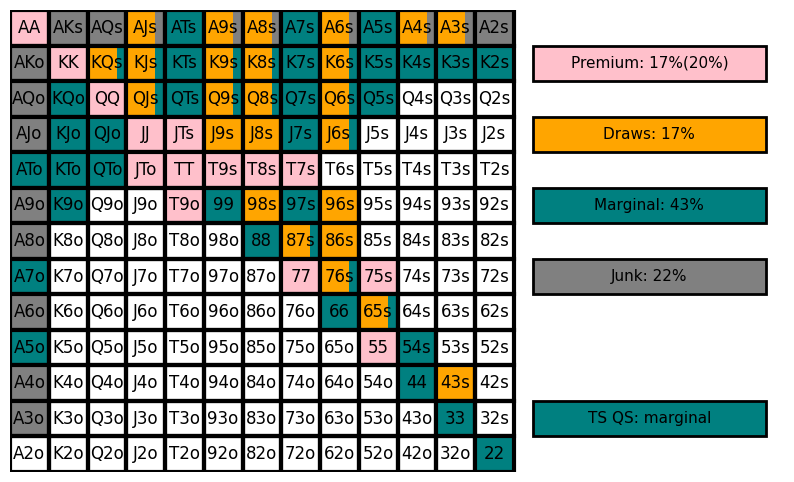

In [158]:
print(hole)
auto_flop(position=position, hole=hole, oop = False, tight_loose = "Loose", seats = 6)